In [1]:
import os
import sys
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

In [3]:
parent = os.path.join(Path(os.getcwd()).parent)

sys.path.append(parent)

from utils.bathymetry import generate_schematized_bathymetry

In [4]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
def read_config(config_file_path):
    '''
    Creates configuration variables from file
    ------
    config_file: .yaml file
        file containing dictionary with dataset creation information
    ''' 

    class AttrDict(dict):
        """
        This class is used to make it easier to work with dictionaries and allows 
        values to be called similar to attributes
        """
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
                                
    with open(config_file_path) as f:
        cfg = yaml.safe_load(f)
        
    config = AttrDict(cfg)
            
    for key in cfg:
        config[key] = AttrDict(cfg[key])
            
    return config

def generate_perpendicular_grids(xgr, zgr, resolution=30, max_depth=3):
    """This function takes an xgrid and a zgrid, as well as a resolution and maximum depth, and returns a (temperature) grid perpendicular to the existing x and z-grid.
    ----------
    xgr: array
        1D array of x-values
    zgr: array
        1D array of z-values
    resolution: integer (default: 30)
        number of desired grid points in the 1D models
    max_depth: float (default: 3)
        maximum depth to be modelled
    ---------Returns----------
    Returns: x_matrix, z_matrix
    
    x_matrix: array
        2D array of x-values. Each row contains the x-values for a 1D model
    z_matrix: array
        2D array of z-values. Each row contains the z-values for a 1D model
    """
    temp_depth_grid = np.linspace(0, max_depth, resolution)
    initial_temp = np.linspace(-5, 5, resolution)

    thermal_matrix = np.zeros((xgr.shape[0], temp_depth_grid.shape[0]))

    for i in range(len(thermal_matrix)):
        thermal_matrix[i,:] = initial_temp
        
    gradient = np.gradient(zgr, xgr)

    orientation = np.arctan(gradient) - 0.5 * np.pi
        
    x_matrix = np.tile(xgr, (len(temp_depth_grid), 1)).T + np.outer(np.cos(orientation), temp_depth_grid)
    z_matrix = np.tile(zgr, (len(temp_depth_grid), 1)).T + np.outer(np.sin(orientation), temp_depth_grid)
    
    return x_matrix, z_matrix



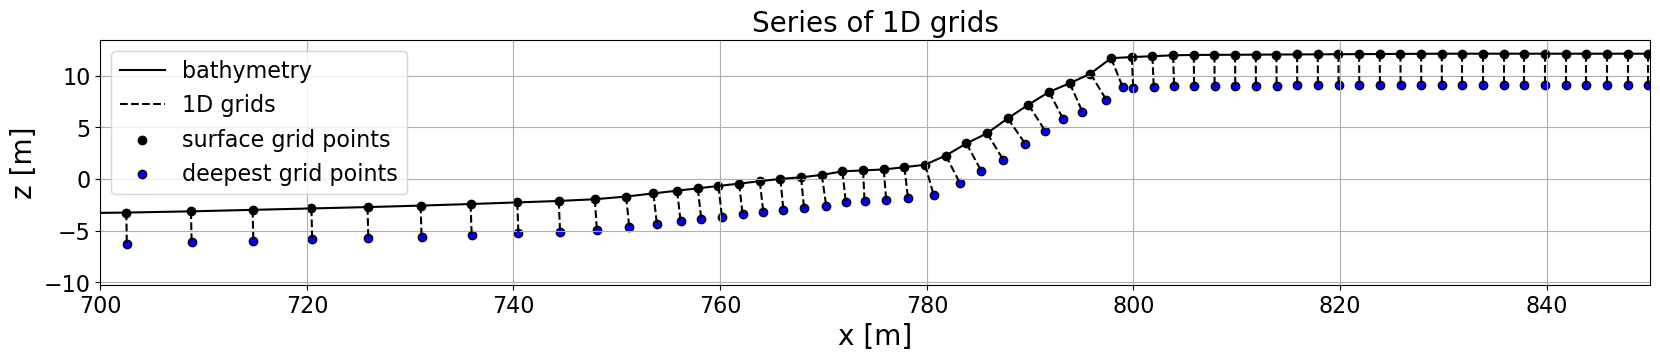

In [6]:
from xbTools.grid.creation import xgrid, ygrid

bathy_grid = np.loadtxt(Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/thermo-morphological-model/database/initial_conditions/x_data.grd"))
bathy_initial = np.loadtxt(Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/thermo-morphological-model/database/initial_conditions/bed_data.dep"))

xgr, zgr = xgrid(bathy_grid, bathy_initial, dxmin=2)

zgr = np.interp(xgr, bathy_grid, bathy_initial)

abs_x1, abs_z2 = generate_perpendicular_grids(xgr, zgr)


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(xgr, zgr, label='bathymetry', color='k')

label_set = False

for x_coords, z_coords in zip(abs_x1, abs_z2):
    if not label_set:
        ax.plot(x_coords, z_coords, '--', color='k', label='1D grids')
        # ax.scatter(x_coords, z_coords, color='k', label='1D grid points')
        
        label_set = True
    else:
        ax.plot(x_coords, z_coords, '--', color='k')
        # ax.scatter(x_coords, z_coords, color='k')
        
ax.scatter(xgr, zgr, color='k', label='surface grid points')
ax.scatter(abs_x1[:,-1], abs_z2[:,-1], fc='b', ec='k', label='deepest grid points')

ax.set_aspect('equal')
ax.set_xlim((700, 850))

ax.legend()

ax.grid()

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')

ax.set_title('Series of 1D grids')

figname = 'thermal_grid.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)


Assuming that the thaw interface is at half the modelling length.

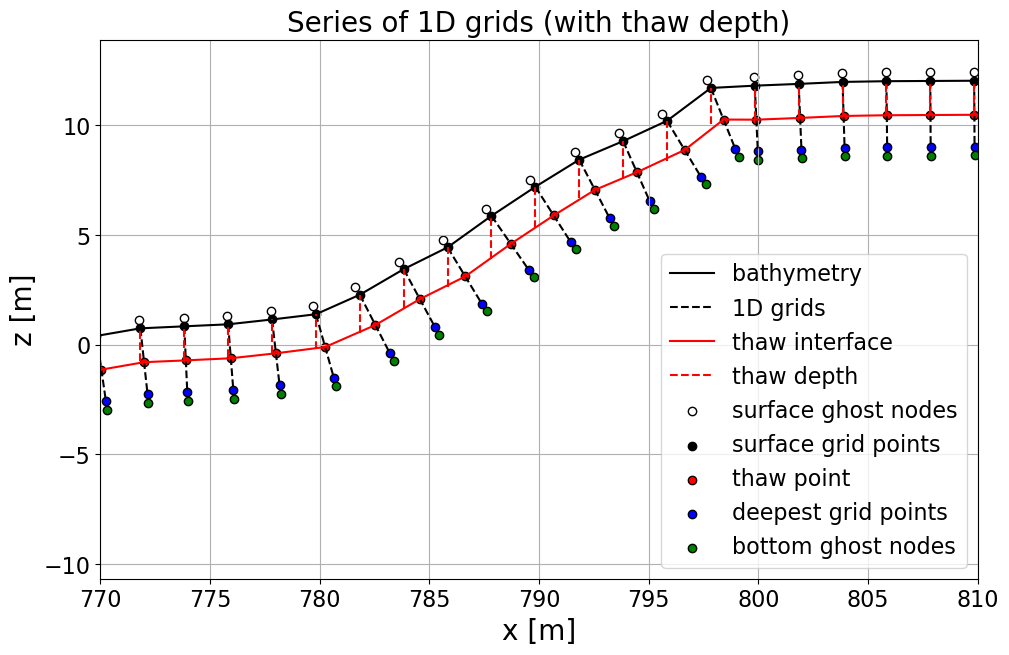

In [7]:
xgr, zgr = xgrid(bathy_grid, bathy_initial, dxmin=2)

zgr = np.interp(xgr, bathy_grid, bathy_initial)

abs_x1, abs_z2 = generate_perpendicular_grids(xgr, zgr)

thaw_x = abs_x1[:, abs_x1.shape[1]//2]
thaw_z = abs_z2[:, abs_x1.shape[1]//2]

sort_i = np.argsort(thaw_x)

thaw_x = thaw_x[sort_i]
thaw_z = thaw_z[sort_i]


angles = np.gradient(zgr, xgr)

# print(angles)

ne_layer = 1.5 / np.cos(angles)

grid_spacing = 0.4

surface_ghost_nodes_x = abs_x1[:,0] - grid_spacing * np.sin(angles)
surface_ghost_nodes_z = abs_z2[:,0] + grid_spacing * np.cos(angles)

bottom_ghost_nodes_x = abs_x1[:,-1] + grid_spacing * np.sin(angles)
bottom_ghost_nodes_z = abs_z2[:,-1] - grid_spacing * np.cos(angles)


fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(xgr, zgr, label='bathymetry', color='k')

label_set = False

for x_coords, z_coords in zip(abs_x1, abs_z2):
    if not label_set:
        ax.plot(x_coords, z_coords, '--', color='k', label='1D grids')
        # ax.scatter(x_coords, z_coords, color='k', label='1D grid points')
        
        label_set = True
    else:
        ax.plot(x_coords, z_coords, '--', color='k')
        # ax.scatter(x_coords, z_coords, color='k')
        

ax.plot(thaw_x, thaw_z, label='thaw interface', color='r')

plt.vlines(x=xgr, ymin=zgr-ne_layer, ymax=zgr, linestyle='dashed', color='r', label='thaw depth')


ax.scatter(surface_ghost_nodes_x, surface_ghost_nodes_z, fc='white', ec='k', label="surface ghost nodes")
ax.scatter(xgr, zgr, fc='k', label='surface grid points')
ax.scatter(thaw_x, thaw_z, label='thaw point', fc='r', ec='k')
ax.scatter(abs_x1[:,-1], abs_z2[:,-1], fc='b', ec='k', label='deepest grid points')
ax.scatter(bottom_ghost_nodes_x, bottom_ghost_nodes_z, fc='g', ec='k', label="bottom ghost nodes")

ax.set_aspect('equal')
ax.set_xlim((770, 810))

ax.legend(loc='lower right')

ax.grid()

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')

ax.set_title('Series of 1D grids (with thaw depth)')

figname = 'thaw_depth_grid.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

# plt.close()

In [8]:
RUNID = "run0"

config_file_path = os.path.join(parent, "runs/", RUNID + "/", "config.yaml")

config = read_config(config_file_path)

In [9]:
xgr_schematized, zgr_schematized = generate_schematized_bathymetry(
    bluff_flat_length=config.bathymetry.bluff_flat_length,

    bluff_height=config.bathymetry.bluff_height, 
    bluff_slope=config.bathymetry.bluff_slope,
    
    beach_width=config.bathymetry.beach_width, 
    beach_slope=config.bathymetry.beach_slope,
    
    nearshore_max_depth=config.bathymetry.nearshore_max_depth, 
    nearshore_slope=config.bathymetry.nearshore_slope,
    
    offshore_max_depth=config.bathymetry.offshore_max_depth, 
    offshore_slope=config.bathymetry.offshore_slope,
    
    contintental_flat_width=config.bathymetry.continental_flat_width,
    
    with_artificial=config.bathymetry.with_artificial,
    artificial_max_depth=config.bathymetry.artificial_max_depth,
    artificial_slope=config.bathymetry.artificial_slope,
    
    N=config.bathymetry.N
)

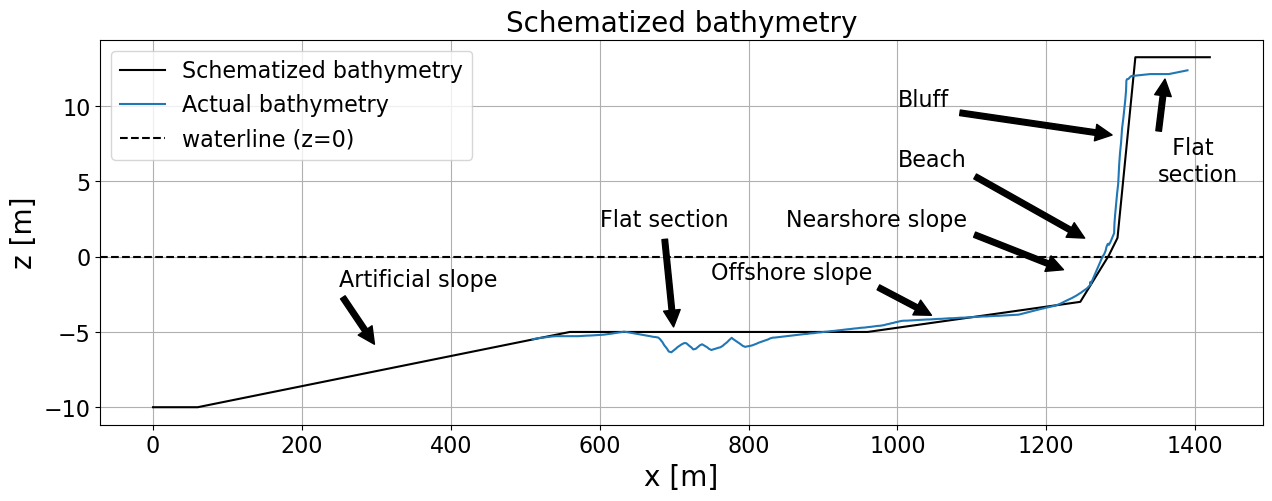

In [11]:
xgr_data = np.loadtxt(os.path.join(parent, "test/", Path("x_data.grd")))
xgr_data += (np.max(xgr_schematized) - np.max(xgr_data)) - 30
zgr_data = np.loadtxt(os.path.join(parent, "test/", Path("bed_data.dep")))

i_wl_data = np.argmin(np.abs(zgr_data))
i_wl_schematized = np.argmin(np.abs(zgr_schematized))


fig, ax = plt.subplots(figsize=(15,5))

ax.plot(xgr_schematized, zgr_schematized, color='k', label='Schematized bathymetry')
ax.plot(xgr_data, zgr_data, color='C0', label='Actual bathymetry')

ax.axhline(0, color='k', linestyle='--', label='waterline (z=0)')

ax.legend()

ax.grid()

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')

ax.set_title('Bathymetry and schematized bathymetry')
# ax.set_title('Schematized bathymetry')

ax.annotate('  Flat\nsection', xy=(1360, 12), xytext=(1350, 5), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Bluff', xy=(1300, 8), xytext=(1000, 10), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Beach', xy=(1260, 1), xytext=(1000, 6), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Nearshore slope', xy=(1230, -1), xytext=(850, 2), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Offshore slope', xy=(1050, -4), xytext=(750, -1.5), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Flat section', xy=(700, -5), xytext=(600, 2), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Artificial slope', xy=(300, -6), xytext=(250, -2), arrowprops=dict(facecolor='black', shrink=0.05))

# plt.show()

figname = 'bathymetry_vs_schematized.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

# plt.close()

In [ ]:
from utils.bathymetry import calculate_bluff_edge_toe_position

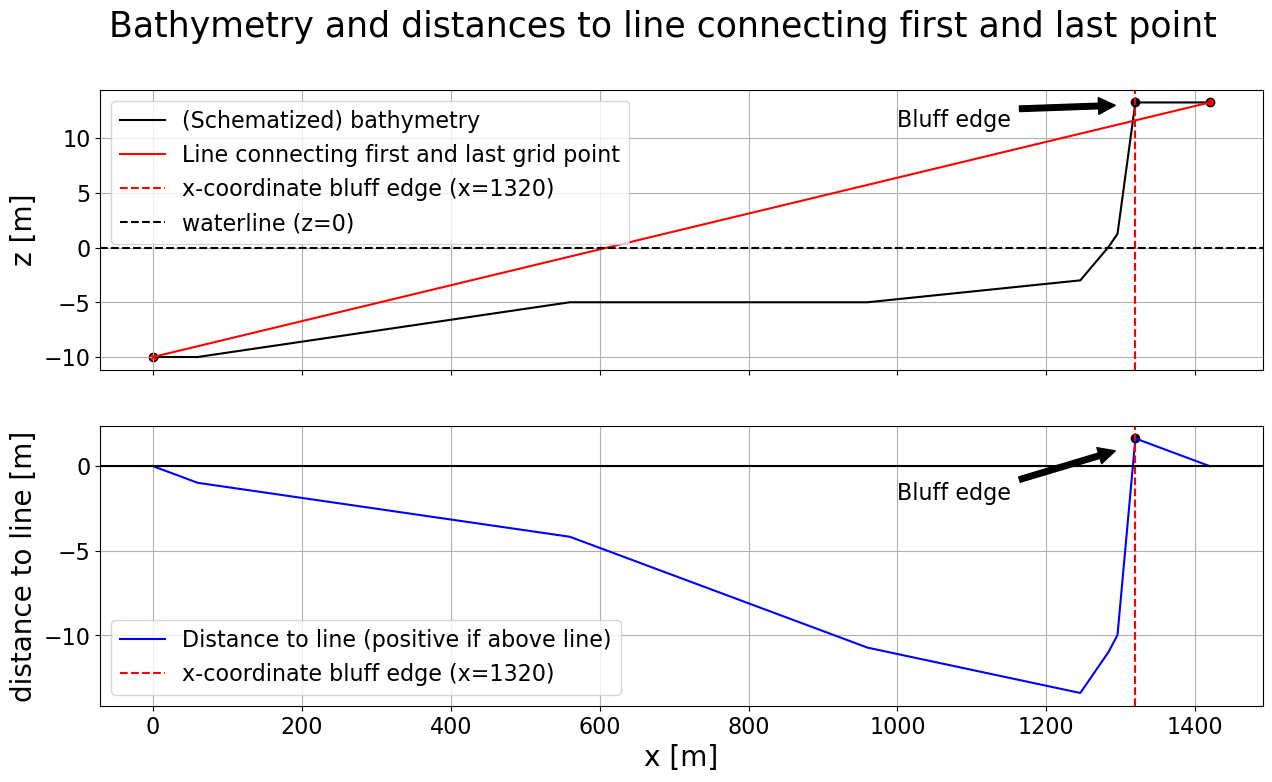

In [ ]:
sort_i = np.argsort(xgr_schematized)

x_sorted = xgr_schematized[sort_i]
z_sorted = zgr_schematized[sort_i]

x_edge, ___, distances = calculate_bluff_edge_toe_position(x_sorted, z_sorted)

# print(x_edge)

ix = np.argmin(np.abs(x_sorted - x_edge))

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

axs[0].scatter(x_sorted[ix], z_sorted[ix], color='k')
axs[0].plot(x_sorted, z_sorted, color='k', label='(Schematized) bathymetry')
axs[0].scatter([x_sorted[0], x_sorted[-1]], [z_sorted[0], z_sorted[-1]], fc='r', ec='k')
axs[0].plot([x_sorted[0], x_sorted[-1]], [z_sorted[0], z_sorted[-1]], color='r', label='Line connecting first and last grid point')

axs[1].scatter(x_sorted[ix], distances[ix], color='k')
axs[1].plot(xgr_schematized, distances, color='b', label='Distance to line (positive if above line)')

axs[0].axvline(x_edge, ls='--', color='r', label=f'x-coordinate bluff edge (x={x_edge:.0f})')
axs[1].axvline(x_edge, ls='--', color='r', label=f'x-coordinate bluff edge (x={x_edge:.0f})')

axs[0].axhline(0, color='k', linestyle='--', label='waterline (z=0)')
axs[1].axhline(0, color='k')

axs[0].legend()
axs[1].legend()

axs[0].grid()
axs[1].grid()

axs[1].set_xlabel('x [m]')
axs[0].set_ylabel('z [m]')
axs[1].set_ylabel('distance to line [m]')

axs[0].annotate('Bluff edge', xy=(1300, 13), xytext=(1000, 11), arrowprops=dict(facecolor='black', shrink=0.05))
axs[1].annotate('Bluff edge', xy=(1300, 1), xytext=(1000, -2), arrowprops=dict(facecolor='black', shrink=0.05))

fig.suptitle("Bathymetry and distances to line connecting first and last point")

# plt.show()

figname = 'bluff_edge_position.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

# plt.close()

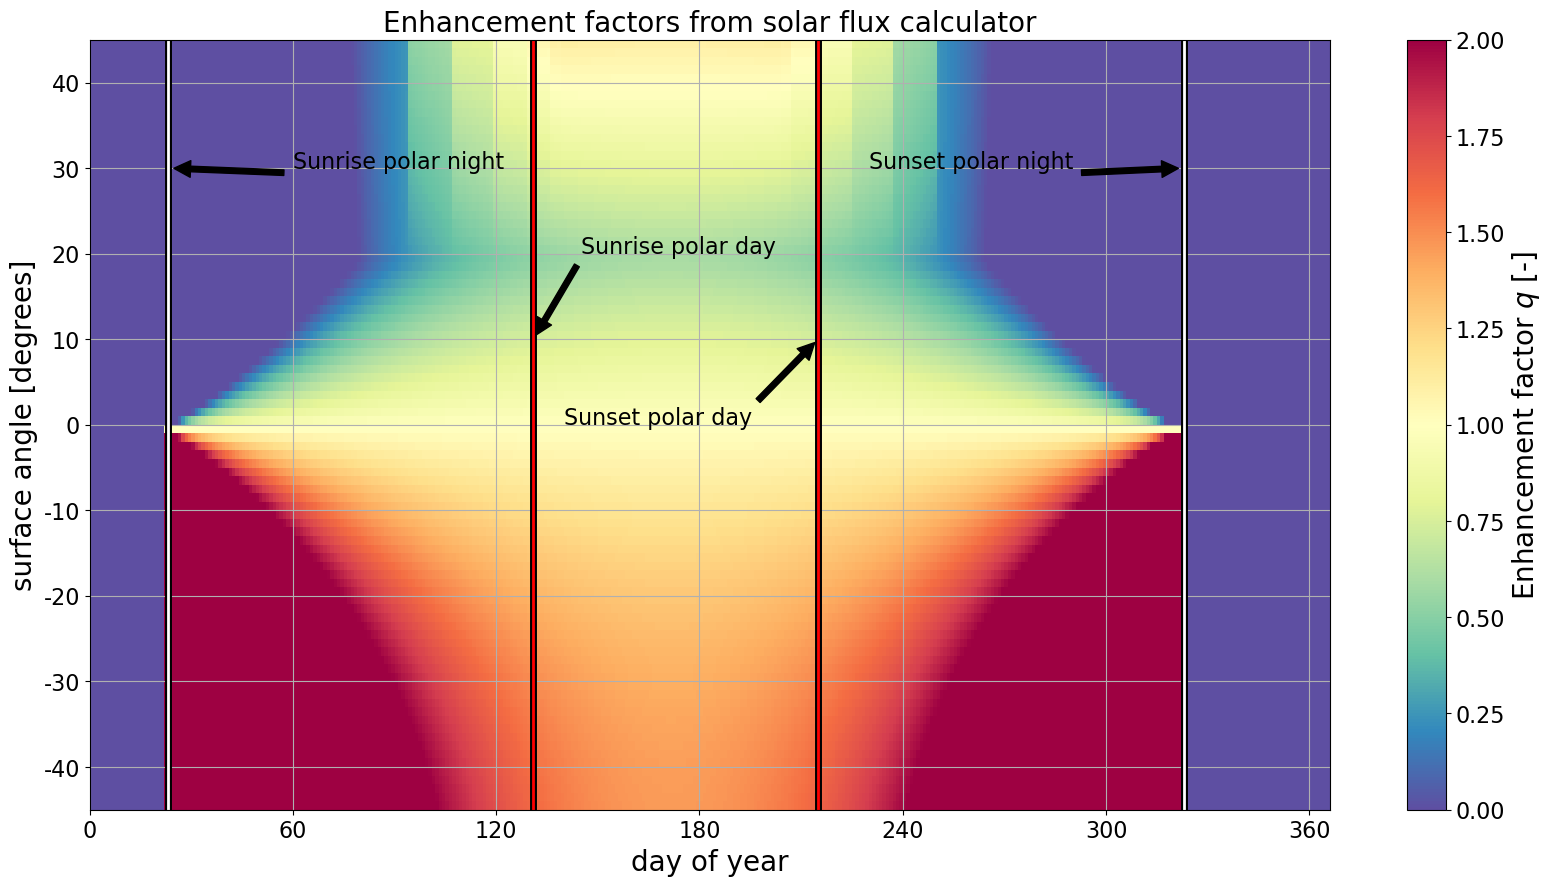

In [ ]:
solar_flux_map = np.loadtxt(os.path.join(os.getcwd(), "solar_flux_map.txt")).T

fig, ax = plt.subplots(figsize=(20, 10))

psm = ax.pcolormesh(solar_flux_map, cmap='Spectral_r', rasterized=True, vmin=0, vmax=2)

plt.colorbar(psm, label='Enhancement factor $q$ [-]')

ax.set_yticks(np.arange(0, 190, 10), np.arange(-90, 100, 10))
ax.set_xticks(np.arange(0, 420, 60), np.arange(0, 420, 60))

ax.set_ylim((45, 135))

ax.grid()

ax.set_ylabel("surface angle [degrees]")
ax.set_xlabel("day of year")

for x in [23, 323]:  # Jan 23rd and november 18th
    ax.axvline(x, ymin=0, ymax=180, color='k', linewidth=5)
    ax.axvline(x, ymin=0, ymax=180, color='white', linewidth=2)
    
for x in [131, 215]:  # May 10th and august 2nd
    ax.axvline(x, ymin=0, ymax=180, color='k', linewidth=5)
    ax.axvline(x, ymin=0, ymax=180, color='r', linewidth=2)

ax.annotate('Sunset polar night', xy=(323, 120), xytext=(230, 120), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Sunrise polar night', xy=(23, 120), xytext=(60, 120), arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate('Sunset polar day', xy=(215, 100), xytext=(140, 90), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Sunrise polar day', xy=(131, 100), xytext=(145, 110), arrowprops=dict(facecolor='black', shrink=0.05))

ax.set_title("Enhancement factors from solar flux calculator")

# during summer, there is a period when the sun doesn't set


figname = 'solar_flux_factors.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

In [ ]:
df_be = pd.read_csv(os.path.join(parent, "database/ts_datasets/bluff_edges.csv"))
df_sl = pd.read_csv(os.path.join(parent, "database/ts_datasets/shore_lines.csv"))

display(df_be.head())

df_be.distance_from_ref.values

,Unnamed: 0,time,distance_from_ref,transect_id,ref_point,geometry
0,0,2000-09-19,0 146.63977\ndtype: float64,134.0,0 POINT (399293.416 7783163.429)\ndtype: ge...,POINT (-143.6562556331044 70.13403816333953)
1,1,2008-06-23,0 158.579708\ndtype: float64,134.0,0 POINT (399293.416 7783163.429)\ndtype: ge...,POINT (-143.65625659182533 70.13393111080923)
2,2,1955-07-24,0 55.670831\ndtype: float64,134.0,0 POINT (399293.416 7783163.429)\ndtype: ge...,POINT (-143.65624832870435 70.13485378355169)
3,3,1950-08-02,0 43.059186\ndtype: float64,134.0,0 POINT (399293.416 7783163.429)\ndtype: ge...,POINT (-143.65624731604254 70.13496685853804)
4,4,1969-07-25,0 84.629681\ndtype: float64,134.0,0 POINT (399293.416 7783163.429)\ndtype: ge...,POINT (-143.656250653975 70.13459414082698)


array(['0    146.63977\ndtype: float64',
       '0    158.579708\ndtype: float64',
       '0    55.670831\ndtype: float64', '0    43.059186\ndtype: float64',
       '0    84.629681\ndtype: float64',
       '0    154.219729\ndtype: float64',
       '0    93.873356\ndtype: float64',
       '0    155.431425\ndtype: float64',
       '0    154.86419\ndtype: float64',
       '0    160.587842\ndtype: float64',
       '0    162.015082\ndtype: float64',
       '0    93.130216\ndtype: float64',
       '0    162.406829\ndtype: float64',
       '0    162.064458\ndtype: float64',
       '0    162.469929\ndtype: float64',
       '0    199.375023\ndtype: float64',
       '0    195.175919\ndtype: float64',
       '0    189.897729\ndtype: float64',
       '0    178.921821\ndtype: float64',
       '0    179.482481\ndtype: float64',
       '0    178.445204\ndtype: float64',
       '0    164.520842\ndtype: float64',
       '0    187.251612\ndtype: float64',
       '0    178.177268\ndtype: float64',
      